# VirtualiZarr Useful Recipes with NASA Earthdata

#### *Author: Dean Henze, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

### ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4

Reading a virtual collection over HTTP

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

#### Prerequisite knowledge

* This notebook covers virtualizarr functionality but does not present the high-level ideas behind it. For an understanding of reference files and how they are meant to enhance in-cloud access to file formats that are not cloud optimized (such netCDF, HDF), please see e.g. this [kerchunk page](https://fsspec.github.io/kerchunk/), or [this page on virtualizarr](https://virtualizarr.readthedocs.io/en/latest/).

* Familiarity with the `earthaccess` and `Xarray` packages. Familiarity with directly accessing NASA Earthdata in the cloud. 

* The Cookbook notebook on [Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) is handy for those new to parallel computating.

#### Learning Outcomes

This notebook serves both as a pedagogical resource for learning several key workflows as well as a quick reference guide. Readers will gain the understanding to combine the virtualizarr and earthaccess packages to read entire datasets by streaming only the areas of interest to the user.

## Import Packages
#### ***Note Zarr Version***
***Zarr version 2 is needed for the current implementation of this notebook, due to (as of February 2025) Zarr version 3 not accepting `FSMap` objects.***

We ran this notebook in a Python 3.12 environment. The minimal working environment we used to run this notebook was:
```
zarr==2.18.4
fastparquet==2024.5.0
xarray==2025.1.2
earthaccess==0.11.0
fsspec==2024.10.0
dask==2024.5.2 ("dask[complete]"==2024.5.2 if using pip)
h5netcdf==1.3.0
matplotlib==3.9.2
jupyterlab
jupyter-server-proxy
virtualizarr==1.3.0
kerchunk==0.2.7
```

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
from virtualizarr import open_virtual_dataset

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import boto3
import numpy as np


In [2]:
virtual_collection = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4_virtual.json"


## Other Setup

In [3]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Get Data File https endpoints


In [4]:
# Get Earthdata creds
earthaccess.login()

In [5]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
# fs = earthaccess.get_s3_filesystem(daac="PODAAC")
fs = earthaccess.get_fsspec_https_session() 

In [6]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.


In [7]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "https", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [9]:
%%time
# Use the above function open the virtual collection. it will take time to download the file.


data_example = opends_withref(virtual_collection, fs)
data_example

CPU times: user 38.2 ms, sys: 8.82 ms, total: 47 ms
Wall time: 708 ms


<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) float64 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>

In [10]:
# Also useful to note, these reference objects don't take much memory:
print(sys.getsizeof(data_example), "bytes")

120 bytes


In [11]:
# Start up cluster and print some information about it:
client = Client(n_workers=15, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(55716265, 'tcp://127.0.0.1:65436', workers=15, threads=15, memory=64.00 GiB)
View any work being done on the cluster here http://127.0.0.1:8787/status


In [12]:
rf = data_example.SALT
rf

<xarray.DataArray 'SALT' (time: 9497, Z: 50, latitude: 360, longitude: 720)> Size: 492GB
dask.array<open_dataset-SALT, shape=(9497, 50, 360, 720), dtype=float32, chunksize=(1, 25, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Z          (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-12-31T...

In [13]:
# Choose a time of interest. 
dates = slice('2017-01-01', '2017-02-28')
rf.sel(time=dates)

<xarray.DataArray 'SALT' (time: 59, Z: 50, latitude: 360, longitude: 720)> Size: 3GB
dask.array<getitem, shape=(59, 50, 360, 720), dtype=float32, chunksize=(1, 25, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Z          (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude   (latitude) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time       (time) datetime64[ns] 472B 2017-01-01T12:00:00 ... 2017-02-28T...

In [14]:
# Choose a region via lat/lon to explore
# Mediterranean Sea
lats = slice(32, 48)
lons = slice(-10, 40)

# Atlantic Ocean Area
# lats = slice(30, 45)
# lons = slice(315, 330)

#gulf of Mexico
#lats = slice(15, 35)
#lons = slice(255, 285)


sss = rf.sel(latitude=lats, longitude=lons, Z=-5, time=dates)
sss

<xarray.DataArray 'SALT' (time: 59, latitude: 32, longitude: 100)> Size: 755kB
dask.array<getitem, shape=(59, 32, 100), dtype=float32, chunksize=(1, 32, 80), chunktype=numpy.ndarray>
Coordinates:
    Z          float32 4B -5.0
  * latitude   (latitude) float32 128B 32.25 32.75 33.25 ... 46.75 47.25 47.75
  * longitude  (longitude) float32 400B -9.75 -9.25 -8.75 ... 38.75 39.25 39.75
  * time       (time) datetime64[ns] 472B 2017-01-01T12:00:00 ... 2017-02-28T...

In [15]:
%%time
sss.load()

CPU times: user 18.4 s, sys: 5.57 s, total: 24 s
Wall time: 1min 43s


<xarray.DataArray 'SALT' (time: 59, latitude: 32, longitude: 100)> Size: 755kB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.323177, 36.323177,       nan, ...,       nan,       nan,
               nan],
        [36.322407, 36.322407, 36.29235 , ...,       nan,       nan,
               nan],
        ...,
        [35.58217 , 35.58217 , 35.58096 , ...,       nan,       nan,
               nan],
        [35.56033 , 35.56033 , 35.560192, ...,       nan,       nan,
               nan],
        [35.53698 , 35.53698 , 35.536327, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.32474 , 36.32474 ,       nan, ...,       nan,       nan,
               nan],
        [36.3235  , 36.3235  , 36.293633, ...,       nan,       nan,
               nan],
...
        [35.576817, 35.576817, 35.57328 , ...,       nan,       nan,
               nan],
        [35.560463, 35.560463, 35.55778 , ...,       nan,       nan,
               nan],
        [35.544586, 35.544586, 35.542027, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [36.297855, 36.297855,       nan, ...,       nan,       nan,
               nan],
        [36.284817, 36.284817, 36.26947 , ...,       nan,       nan,
               nan],
        ...,
        [35.575344, 35.575344, 35.57152 , ...,       nan,       nan,
               nan],
        [35.559414, 35.559414, 35.55634 , ...,       nan,       nan,
               nan],
        [35.543713, 35.543713, 35.540752, ...,       nan,       nan,
               nan]]], shape=(59, 32, 100), dtype=float32)
Coordinates:
    Z          float32 4B -5.0
  * latitude   (latitude) float32 128B 32.25 32.75 33.25 ... 46.75 47.25 47.75
  * longitude  (longitude) float32 400B -9.75 -9.25 -8.75 ... 38.75 39.25 39.75
  * time       (time) datetime64[ns] 472B 2017-01-01T12:00:00 ... 2017-02-28T...

## Results
The `%%time` allows us to see how long a particular cell took. On my machine, over wireless internet, it took me 1m 43s to access 2 months of the ECCO data for my region of interest. to download this data and analyze on your laptop, even for a small region, would be close to 530MB of data. Now that we have the data for our region locally, we can explore it:

(array([ 8790.,  1448.,  5428.,  2164.,  2664.,  4026.,  8872.,  9910.,
        13522., 14684.]),
 array([35.30804825, 35.7061615 , 36.10427094, 36.50238419, 36.90049362,
        37.29860687, 37.69672012, 38.09482956, 38.49294281, 38.89105225,
        39.2891655 ]),
 <BarContainer object of 10 artists>)

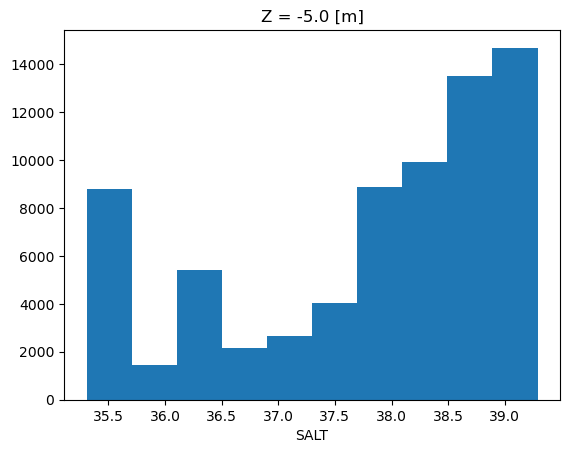

In [16]:
sss.plot()

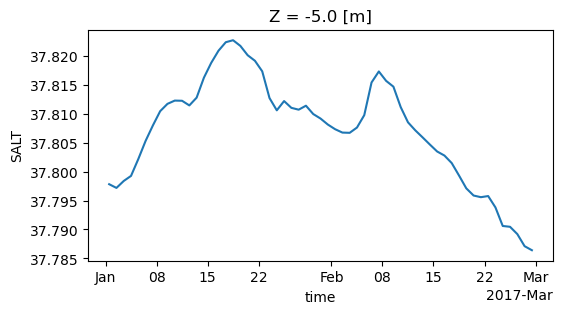

In [17]:
mean_sss = sss.mean(dim=["latitude","longitude"])
mean_sss.plot(aspect=2, size=3)


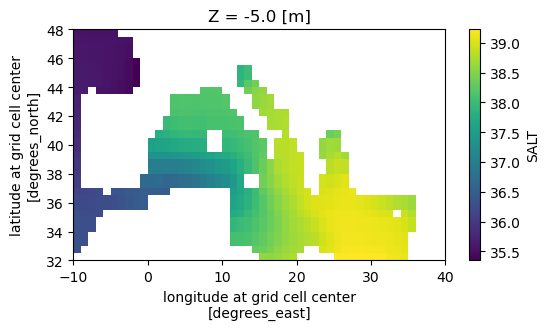

In [18]:
sss.mean(dim=["time"]).plot(aspect=2, size=3)